## Exponea Data Analytics Challenge 

**Author:** Štefan Konečný

**Email:** konecny.mokum@gmail.com

**Date:** 15 February 2017

### Preview of the Data

Let us have a brief look at the data first:

In [12]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

startup_df = pd.read_csv("Startup_Data.csv")
display(startup_df.head())

print "Number of companies "+str(startup_df.index.size)

startup_df[["Company_Name", "Dependent-Company Status"]].groupby( ["Dependent-Company Status"] ).count()

import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

,Company_Name,Dependent-Company Status,year of founding,Age of company in years,Internet Activity Score,Short Description of company profile,Industry of company,Focus functions of company,Investors,Employee Count,...,Percent_skill_Data Science,Percent_skill_Business Strategy,Percent_skill_Product Management,Percent_skill_Sales,Percent_skill_Domain,Percent_skill_Law,Percent_skill_Consulting,Percent_skill_Finance,Percent_skill_Investment,Renown score
0,Company1,Success,No Info,No Info,-1.0,Video distribution,NaN,operation,KPCB Holdings|Draper Fisher Jurvetson (DFJ)|Kl...,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Company2,Success,2011,3,125.0,NaN,Market Research|Marketing|Crowdfunding,"Marketing, sales",NaN,NaN,...,8.823529412,21.76470588,10.88235294,2.941176471,0,0,0,0,0,8
2,Company3,Success,2011,3,455.0,Event Data Analytics API,Analytics|Cloud Computing|Software Development,operations,TechStars|Streamlined Ventures|Amplify Partner...,14.0,...,3.846153846,17.09401709,9.401709402,0,2.777777778,0,0,0,0,9
3,Company4,Success,2009,5,-99.0,The most advanced analytics for mobile,Mobile|Analytics,Marketing & Sales,Michael Birch|Max Levchin|Sequoia Capital|Keit...,45.0,...,0,0,0,0,0,0,0,0,0,5
4,Company5,Success,2010,4,496.0,The Location-Based Marketing Platform,Analytics|Marketing|Enterprise Software,Marketing & Sales,DFJ Frontier|Draper Nexus Ventures|Gil Elbaz|A...,39.0,...,0,0,0,0,0,0,0,0,0,6


Number of companies 472


Toggle code

We have 472 different companies and 116 variables describing each.

Surprisingly, there are almost twice as many successful companies (305) as failed ones (167). This is of course **VERY SUSPICIOUS** and likely an indication of a synthetic data set. In real life most companies fail.

More importantly, it means I have to be very careful to **AVOID OVERFITTING**, since I have much more data on successful companies the on failed ones.

### My approach

1. Divide companies into two distinct groups:  successful(S) and failed(F) ones
1. Create normalized histograms for each variable
1. Detect significant differences between histograms for S and F companies

Because the there are much more S companies then F companies I will use normalized histograms for comparing variables (and their values). To make such comparison accurate, I make sure that:

1. **Bin boundaries are the same** for S and F
1. Each bins contains a **percentage of total companies** (in contrast to the number of companies) falling into the bin

In [13]:
success_df = startup_df[startup_df["Dependent-Company Status"]=="Success"].reset_index()
failed_df = startup_df[startup_df["Dependent-Company Status"]=="Failed"].reset_index()

df_sf = (success_df,failed_df)

def normalize_double_hist(data, bins = 20, h_range = None):
    if (h_range == None):
        min_val = min(data[0].min(),data[1].min())
        max_val = max(data[0].max(),data[1].max())
    else:
        min_val = h_range[0]
        max_val = h_range[1]
    
    # if there are both + and - values center on 0, 0 has often a special meaning 
    # so it sholdn't be in a centre of a bin    
    if (min_val * max_val) < 0:
        max_val = max(abs(min_val),max_val)
        min_val = -max_val
        
    #get histograms
    hist0, bin_edges = np.histogram(data[0], bins, range =  (min_val,max_val))
    hist1, _ = np.histogram(data[1], bins, range =  (min_val,max_val))
    
    #normalize histograms
    n_hist0 = hist0.astype(np.float32) / hist0.sum()
    n_hist1 = hist1.astype(np.float32) / hist1.sum()
    
    return (bin_edges,n_hist0,n_hist1) 

### Preprocessing variables

The function I wrote to calculate normalized histograms, works on numerical data only. To apply it on the dataset, I needed to divide variables into specific groups, each requiring a specialist treatment.

1.  Numerical variables
   * Can occasionally contain a string (e.g. 'No value') - I had to remove such cases
   * If there are both negative and positive value, 0 should be at the border of histogram bin(s)
   
2. Categorical variables
   * Fall into a small number of categories (e.g. 'yes'/'no')
   * Each histogram bin corresponds to exactly one category
   * Their values can be case sensitive (e.g. 'yes'/'Yes'/'YES')

3. Other variables
   * Unique strings ('Company_Name')
   * Set of values ('Industry of company')

I was able to divide the variables into categories and process them fully automatically. Human processing would also work for the dataset of this size. It might be problematic for larger datasets.

In [14]:
cat_var = []
lower_var = []
num_var = []
other_var = []

def split_variables(index, data = df_sf, cv = cat_var, lv = lower_var, nv = num_var, ov =other_var):
    s_col = data[0].iloc[:,index].dropna()
    f_col = data[1].iloc[:,index].dropna()
    
    t_size = float(s_col.size+f_col.size) 
    
    #unique vals
    unique_vals = np.append(s_col.unique(),f_col.unique())
    unique_vals = np.unique(unique_vals)
    
    u_size = float(unique_vals.size)
    
    #probably categorical
    if ((u_size / t_size) < 0.05):
        cv += [index]
        
        #try cat to lower
        l_vals = pd.Series(unique_vals).apply(lambda x: str(x).lower())
        l_vals = np.unique(l_vals)
        l_size = float(l_vals.size)
        
        #if cast made a difference remember this
        if (u_size > l_size):
            lv += [index]
    else:
    #try numbers
        num_vals = pd.Series(unique_vals).apply(lambda x: pd.to_numeric(x, errors='coerce'))
        num_vals = num_vals.dropna()
        
        n_size = float(num_vals.size)
        
        #if the majority is numbers
        if ((n_size / u_size) > 0.9):
            nv += [index]
        #well something else
        else:
            ov += [index]

for i in range(1,117):
    split_variables(i)

In [15]:
#very long function which does all the work. Returns true if it finds some promissing bins
#it also can plot histograms and print out some statistical characeristics
def survey_column(index, data = df_sf, first_n = 20, bins = 50, force_num = False,\
                  cat = False, ratio = 2, min_p = 0.05, drop_p = 0.1,\
                  print_out = False, draw_hist = False, print_uvals = False):
    
    name = data[0].columns[index]
    
    if print_out:
        print str(index)+" "+ name
    
    s_col = data[0].iloc[:,index]
    f_col = data[1].iloc[:,index]
    
    s_size = s_col.size
    f_size = f_col.size
    
    #show first size rows
    ccol_df = pd.concat([s_col.iloc[0:first_n,],f_col.iloc[0:first_n,]], axis =1)
    #rename columns
    ccol_df.columns =["S:"+name,"F:"+name]
    
    if print_out:
        display(ccol_df)

    s_col = s_col.dropna()
    f_col = f_col.dropna()
    
    if (cat):
        unique_vals = np.append(s_col.unique(),f_col.unique())
        unique_vals = np.unique(unique_vals)
        unique_vals = np.sort(unique_vals)
        
        # print out first nr_vals
        if print_out:
            if unique_vals.size > first_n:
                print unique_vals[0:first_n]
        elif print_uvals:
            print str(index)+" "+ name
            print unique_vals
                
        #cast categories into indexes
        s_col = s_col.apply(lambda x: np.searchsorted(unique_vals,x))
        f_col = f_col.apply(lambda x: np.searchsorted(unique_vals,x))


    #force casting into numbers
    elif force_num:
        s_col = s_col.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        f_col = f_col.apply(lambda x: pd.to_numeric(x, errors='coerce'))
  
        s_col = s_col.dropna()
        f_col = f_col.dropna()
        
    
    s_dropped =(s_size-s_col.size)/float(s_size)
    f_dropped =(f_size-f_col.size)/float(f_size)
    
    if print_out:
        print "Dropped values S/F: {0:2.2f}% / {1:2.2f}%".format(s_dropped*100, f_dropped*100)
    
    #do df summaries
    
    cdes_df = pd.concat([s_col.describe(),f_col.describe()], axis =1)
    #rename columns
    cdes_df.columns =["S:"+name,"F:"+name]
    
    #count how many values there were before preprocessing (before removing weird valeus)
    f_line = pd.DataFrame({"S:"+name: [len(success_df.index)],"F:"+name:[len(failed_df.index)]}, index = ["t_count"])
    
    #prepend fline
    cdes_df = pd.concat([f_line,cdes_df])
    
    if print_out:
        display(cdes_df)

    #get histograms with categorical variables # bins = # categories
    if (cat):
        b, nh_s, nh_f =normalize_double_hist((s_col,f_col),\
                                       bins = unique_vals.size)
    else:
        b, nh_s, nh_f =normalize_double_hist((s_col,f_col),\
                                       bins = bins)
    
    if draw_hist:
        fig, ax = plt.subplots(2,2, figsize=(15,6))

        max_hist = max (nh_s.max(), nh_f.max())

        step = b[1] - b[0]

        scale = 1.1

        ax[0,0].bar(b[:-1], nh_s, width= step, color='green')    
        ax[0,0].set_title("S:"+name)
        ax[0,0].set_xlim([b[0]*scale,b[-1]*scale])
        ax[0,0].set_ylim([0,max_hist])

        ax[0,1].bar(b[:-1], nh_f, width= step, color='red')
        ax[0,1].set_title("F:"+name)
        ax[0,1].set_xlim([b[0]*scale,b[-1]*scale])
        ax[0,1].set_ylim([0,max_hist*scale])

        s_less = nh_s *(nh_s <= nh_f)
        ax[1,0].bar(b[:-1], nh_s, width= step, color='green')
        ax[1,0].bar(b[:-1], nh_f, width= step, color='red')
        ax[1,0].bar(b[:-1], s_less, width= step, color='green')
        ax[1,0].set_title("Both")
        ax[1,0].set_xlim([b[0]*scale,b[-1]*scale])
        ax[1,0].set_ylim([0,max_hist*scale])

#     alternative plotting
#     s_diff = nh_s - nh_f
#     ax[1,1].bar(b[:-1], s_diff, width= step, color='orange')
#     ax[1,1].set_title("Diff")
#     ax[1,1].set_xlim([b[0]*scale,b[-1]*scale])
#     ax[1,1].set_ylim([s_diff.min()*scale,s_diff.max()*scale])
    
#     s_more = (nh_s > nh_f)    
#     f_less_val = s_more * nh_f;
#     f_less_val_neg = f_less_val * -1;
    
    
#     ax[1,1].bar(b[:-1], f_less_val_neg, width= step, color='blue')
#     ax[1,1].set_ylim([min(s_diff.min(),f_less_val_neg.min())*scale,s_diff.max()*scale])
    
    
    #calculate ratio between success and fialure
    sf_ratio = nh_s/nh_f
    # remove inf, inf nan
    sf_ratio[np.logical_not(np.isfinite(sf_ratio))] = 0
    
    
    #ignore entries below ratio
    sf_ratio[(sf_ratio<ratio)] =  0
    #ignore entries not frequent enough
    sf_ratio[(nh_s <= min_p)] =  0
    
    #only sucessess, no fialures in the bin
    s_pos = np.copy(nh_s)
    
    s_pos[nh_f !=0] = 0
    # to small cut it off
    s_pos[(nh_f ==0) & (nh_s <= min_p)] = 0
    # seems significan keep it
    s_pos[(nh_f ==0) & (nh_s > min_p)] = 1
    
    if draw_hist:    
        if sf_ratio.sum()>0:
            ax[1,1].bar(b[:-1], sf_ratio, width= step, color='blue')
            ax[1,1].set_ylim([0,sf_ratio.max()*scale])
        
        if s_pos.sum()>0:
        #this is scaled to ratio so it is always visible
            ax[1,1].bar(b[:-1], s_pos*ratio, width= step, color='orange')

        ax[1,1].set_title("S/F ratio above "+str(ratio))
        ax[1,1].set_xlim([b[0]*scale,b[-1]*scale])
    
    
    #shorten the arraus and keep only significant values
    short_ratio = np.copy(sf_ratio)
    short_ratio = short_ratio[sf_ratio>=ratio]    
    #-1 for sorting desc
    short_ratio = np.sort(-1 *short_ratio)*-1
    
    #isnt dropout too much
    drop_ok = ((f_dropped< drop_p) and (s_dropped< drop_p)) 
    
    looks_good = False
        
    if (short_ratio.size> 0) and (drop_ok):
        if (cat): #(cat and print_out):
            print "vals: " + str(unique_vals[sf_ratio>=ratio])
        
        print "ratio: " + str(sf_ratio[sf_ratio>=ratio])
        print "suc: " +str(nh_s[sf_ratio>=ratio])
        
        looks_good = True 
        print "sorted ratio: "+str(short_ratio)
        print "***"
            
    #sort only the suc > min_p
    only_suc = s_pos * nh_s
    short_suc = np.copy(only_suc)
    short_suc = short_suc[only_suc>0] 
    #-1 for sorting desc
    short_suc = np.sort(-1 *short_suc)*-1
    
    if (short_suc.size>0) and (drop_ok):
        if (cat): #(cat and print_out):
            print "val: " +str(unique_vals[only_suc>0])
        
        print "no_fail: " +str(nh_s[only_suc>0])
        
        looks_good = True
        print "sorted no_fail: " +str(short_suc)
        print "***"
        
    
    if looks_good:
        print "Dropped values S/F: {0:2.2f}% / {1:2.2f}%".format(s_dropped*100, f_dropped*100)
        print str(index)+" "+ name
        if cat:
            print unique_vals
        
    return looks_good


### Identifying promising Variable and Value pairs

Let me demonstrate my approach on a concrete example. Let us consider the variable **'Client Reputation'** (column 87 of the dataset). Let us start of with graphs (histograms) first.


vals: ['Low']
ratio: [ 10.31202126]
suc: [ 0.3704918]
sorted ratio: [ 10.31202126]
***
Dropped values S/F: 0.00% / 0.00%
87 Client Reputation
['High' 'Low' 'Medium' 'No Info']


True

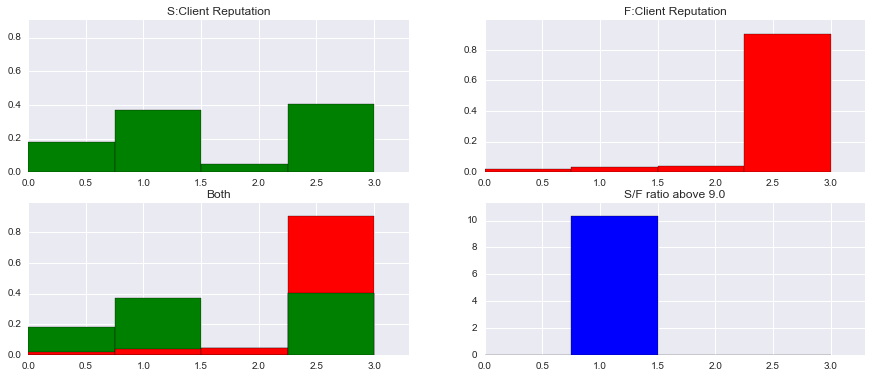

In [16]:
survey_column(87, force_num = False, cat = True,\
                            ratio = 9.0, min_p = 0.20, drop_p = 0.1,\
                            print_out = False, draw_hist = True, print_uvals = False)

Variable **'Client Reputation'** can take 4 possible values: 'High', 'Low', 'Medium' and 'No Info'. Each bar of the graph (bin of the histogram) corresponds to one such possible value in the given order. First bar from the left represents the value 'High', the next represents 'Low' and so on.

The two top graphs visualize the distribution of values among successful companies (green graph) and failed companies (red graph). I am mostly interested in the **ratio** of successful and failed companies (**S/F**) for each possible value (bottom left graph, therefore it contains both green and red bars).

If the ration **S/F** is high enough (in this case 10.31, higher then desired **ratio** 9.0, the first criterion), I consider the variable value pairing (in this case **'Client Reputation'** and **'Low'**) a promising indicator of success.

I also consider two additional criteria. First one is whether the value occurs often enough. In this case 'Low' occurs in over 37% of cases among successful companies, well over the desired 20 % (**min_p**, the second criterion).

The last criterion considers many values were removed during pre processing step (it should be below ** drop_p **, the third criterion). Such removal indicates a lot of missing values in the dataset. This is often the case among **non-categorical variables**, in particular for **failed companies**. Often more then 20% of failed companies don't have a proper value filled in. This creates a lot of ambiguity and makes impossible to reliably distinguish success from failure.

For this reason I have focused on **categorical variables**. For them, values are typically known both for successful and failed companies. For this particular variable ('Client Reputation') the value is known for every company (and thus 0% of values had to be dropped during pre processing, far less then allowed maximum 10%).

### Results

I have analysed every variable in the dataset as described above. I have identified three very promising variable/value pairings. All the variables are categorical:

1. "Number of  of Partners of company" with value "Few"
1. "Experience in selling and building products" with value "High"
1. "Client Reputation" with value "Low"

These pairing were found with following settings:

1. S/F ratio is 9.0 or above (ratio = 9.0)
1. At least 20% of successful companies have the selected value (min_p = 0.20)
1. At most 10% values was discarded during pre- processing (drop_p = 0.1)

Then I found companies with the desired variable/value pairs in the dataset. There are 25 such companies and all of them are successful.

My list is dominated by US companies (as is the dataset), but it also contains one company from UK and one from Spain. The focus and age of the companies is quite varied. This diversity makes my list a good candidate for a varied portfolio.

I would still recommend to look for a larger and more comprehensive dataset. In particular I had very little data on failed companies, and the (particularly numeric variables) data I had was often incomplete.

But given the provided dataset, the 25 identified companies look as a very promising investment to me.

In [17]:
#print prom_names

filt = (startup_df["Number of  of Partners of company"] == "Few")
filt = filt &(startup_df["Experience in selling and building products"] == "High")
filt = filt &(startup_df["Client Reputation"] == "Low")

final_res =(startup_df[["Company_Name", "Dependent-Company Status",\
                       "Focus functions of company",\
                       "Country of company",\
                       "year of founding"]][filt])

print "Nr Companies: " +str(final_res.index.size)
display(final_res)

Nr Companies: 25


,Company_Name,Dependent-Company Status,Focus functions of company,Country of company,year of founding
2,Company3,Success,operations,United States,2011
4,Company5,Success,Marketing & Sales,United States,2010
8,Company9,Success,Marketing,United States,2011
11,Company12,Success,operations,United States,2010
12,Company13,Success,Marketing \r\nsales,United States,2010
103,Company104,Success,service,United Kingdom,2009
106,Company107,Success,operation,United States,2008
107,Company108,Success,"Marketing, Sales",United States,2011
108,Company109,Success,Marketing,United States,2010
111,Company112,Success,operations,United States,2012


### Post Submission: Does capitalization of values make a difference

The are number of variables for which values differ only in capitalization (eg. 'YES' vs 'Yes' vs 'yes'). I was curious whether this is just textual noise. Alternatively the type of capitalization may indicate degree of certainty (strong YES vs weak yes). In that case the values should be more explicit, to avoid speculations.

The analysis above was case sensitive. So 'YES','Yes' and 'yes' were treated as three different values. Now I will create new columns (distinguish by name prefix "lc:") where all different values are mapped into a single lower cast value (e.g. 'yes' instead of YES','Yes' and 'yes'). And I will analyse whether theses new columns are a strong predictor of success/failure.

In [18]:
print lower_var

i = 0

for i_col in lower_var:
    name = success_df.columns[i_col]
    name = "lc: "+name
    
    col = success_df.iloc[:, i_col]
    print name
    print np.unique(col)
    
    l_vals = pd.Series(col).apply(lambda x: str(x).lower())
    
    success_df[name] = l_vals

    col = failed_df.iloc[:, i_col]
    l_vals = pd.Series(col).apply(lambda x: str(x).lower())
    
    failed_df[name] = l_vals

[12, 26, 39, 40]
lc: Has the team size grown
[nan 'No' 'No Info' 'YES' 'Yes' 'yes']
lc: Number of  Sales Support material
['No Info' 'Nothing' 'high' 'low' 'medium']
lc: Cloud or platform based serive/product?
['Both' 'Cloud' 'Platform' 'cloud' 'none']
lc: Local or global player
['GLOBAL' 'GLObaL' 'Global' 'LOCAL' 'Local' 'No Info' 'global' 'local']


Even for the most promising column (nr. 118) the S\F ration is not nearly high enough to consider it as a predictor.

vals: ['high' 'medium']
ratio: [ 7.44655752  3.10273218]
suc: [ 0.22295082  0.33442622]
sorted ratio: [ 7.44655752  3.10273218]
***
Dropped values S/F: 0.00% / 0.00%
118 lc: Number of  Sales Support material
['high' 'low' 'medium' 'no info' 'nothing']


True

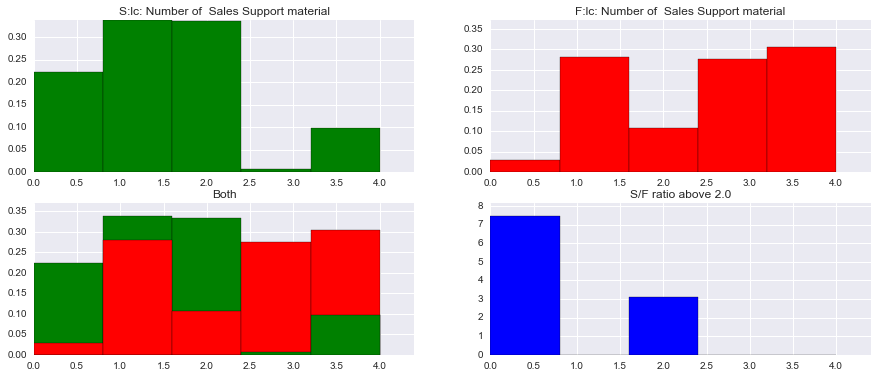

In [59]:
#test whether the downcast has worked as expected
#print success_df.iloc[:,[lower_var[3],120]].head(20)
#print np.unique(success_df.iloc[:, lower_var[3]])
#print np.unique(success_df.iloc[:, 120])

survey_column(118, force_num = False, cat = True,\
                            ratio = 2.0, min_p = 0.2, drop_p = 0.1,\
                            print_out = False, draw_hist = True, print_uvals = False)